In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from torch.utils.data import DataLoader
from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [8]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    logger_kwargs={'show': True, 'update_step':20},
    device=device
)

In [9]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(X_val, y_val, dtype_X='float', dtype_y='float')

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=32)
val_loader = DataLoader(val_wrapper, batch_size=32)

In [10]:
# fitting process
trainer.fit(train_loader, val_loader, epochs=5000)

INFO:root:Epoch 1/5000 | Train loss: 7215.00830078125 | Validation loss: 8710.00390625 | Time/epoch: 0.21278 seconds
INFO:root:Epoch 20/5000 | Train loss: 7147.640625 | Validation loss: 8631.4541015625 | Time/epoch: 0.04099 seconds
INFO:root:Epoch 40/5000 | Train loss: 7077.56396484375 | Validation loss: 8549.6181640625 | Time/epoch: 0.0427 seconds
INFO:root:Epoch 60/5000 | Train loss: 7008.19189453125 | Validation loss: 8468.501953125 | Time/epoch: 0.04056 seconds
INFO:root:Epoch 80/5000 | Train loss: 6939.48486328125 | Validation loss: 8388.0615234375 | Time/epoch: 0.04099 seconds
INFO:root:Epoch 100/5000 | Train loss: 6871.41064453125 | Validation loss: 8308.265625 | Time/epoch: 0.04599 seconds
INFO:root:Epoch 120/5000 | Train loss: 6803.94189453125 | Validation loss: 8229.0859375 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 140/5000 | Train loss: 6737.056640625 | Validation loss: 8150.49853515625 | Time/epoch: 0.03901 seconds
INFO:root:Epoch 160/5000 | Train loss: 6670.7353515625 

INFO:root:Epoch 1380/5000 | Train loss: 3419.3505859375 | Validation loss: 4154.734375 | Time/epoch: 0.0383 seconds
INFO:root:Epoch 1400/5000 | Train loss: 3376.69775390625 | Validation loss: 4102.4892578125 | Time/epoch: 0.03897 seconds
INFO:root:Epoch 1420/5000 | Train loss: 3334.34814453125 | Validation loss: 4050.604736328125 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 1440/5000 | Train loss: 3292.296630859375 | Validation loss: 3999.074951171875 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 1460/5000 | Train loss: 3250.537109375 | Validation loss: 3947.893310546875 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 1480/5000 | Train loss: 3209.071533203125 | Validation loss: 3897.0625 | Time/epoch: 0.03897 seconds
INFO:root:Epoch 1500/5000 | Train loss: 3167.90478515625 | Validation loss: 3846.58984375 | Time/epoch: 0.041 seconds
INFO:root:Epoch 1520/5000 | Train loss: 3127.042236328125 | Validation loss: 3796.482177734375 | Time/epoch: 0.03998 seconds
INFO:root:Epoch 1540/5000 | Tra

INFO:root:Epoch 2720/5000 | Train loss: 1191.03955078125 | Validation loss: 1419.8583984375 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 2740/5000 | Train loss: 1167.1492919921875 | Validation loss: 1390.5927734375 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 2760/5000 | Train loss: 1143.5260009765625 | Validation loss: 1361.6585693359375 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 2780/5000 | Train loss: 1120.1793212890625 | Validation loss: 1333.067626953125 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 2800/5000 | Train loss: 1097.1131591796875 | Validation loss: 1304.824951171875 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 2820/5000 | Train loss: 1074.3209228515625 | Validation loss: 1276.9227294921875 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 2840/5000 | Train loss: 1051.800537109375 | Validation loss: 1249.3577880859375 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 2860/5000 | Train loss: 1029.5433349609375 | Validation loss: 1222.1199951171875 | Time/epoch: 0.03897 sec

INFO:root:Epoch 4040/5000 | Train loss: 187.2574920654297 | Validation loss: 200.24351501464844 | Time/epoch: 0.04097 seconds
INFO:root:Epoch 4060/5000 | Train loss: 180.79571533203125 | Validation loss: 192.62442016601562 | Time/epoch: 0.03999 seconds
INFO:root:Epoch 4080/5000 | Train loss: 174.57679748535156 | Validation loss: 185.30645751953125 | Time/epoch: 0.03999 seconds
INFO:root:Epoch 4100/5000 | Train loss: 168.61151123046875 | Validation loss: 178.3018798828125 | Time/epoch: 0.04199 seconds
INFO:root:Epoch 4120/5000 | Train loss: 162.89109802246094 | Validation loss: 171.60025024414062 | Time/epoch: 0.03799 seconds
INFO:root:Epoch 4140/5000 | Train loss: 157.41856384277344 | Validation loss: 165.2050018310547 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 4160/5000 | Train loss: 152.1909637451172 | Validation loss: 159.11209106445312 | Time/epoch: 0.03899 seconds
INFO:root:Epoch 4180/5000 | Train loss: 147.20584106445312 | Validation loss: 153.31874084472656 | Time/epoch: 0.03

In [11]:
# predictions
with torch.no_grad():
    y_pred = model(torch.from_numpy(X_val).float().to(device)).cpu().numpy()

In [12]:
import matplotlib.pyplot as plt

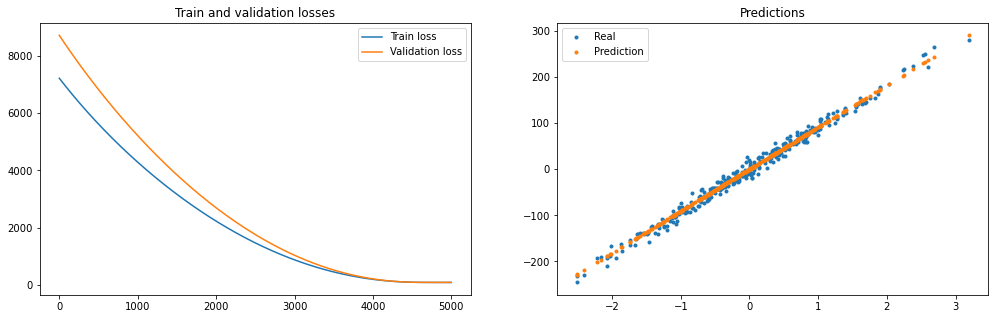

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5))

ax[0].plot(trainer.train_loss_, label='Train loss')
ax[0].plot(trainer.val_loss_, label='Validation loss')
ax[0].set_title('Train and validation losses')
ax[0].legend();

ax[1].plot(X_val, y_val, '.', label="Real")
ax[1].plot(X_val, y_pred, '.', label="Prediction")
ax[1].set_title('Predictions')
ax[1].legend();